Alexander W. Criswell 10/9/25

I have now added instrumental noise to resolve the -inf log likelihood at foreground truncation. Perhaps *this* time it will work!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cupy as xp
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
# import jax.numpy as jnp
# import jax; jax.config.update("jax_enable_x64", True)
from corner import corner, overplot_lines
import legwork as lw
import astropy.units as u
from tqdm import tqdm
from math import factorial
plt.style.use('default')

In [3]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove, DistributionGenerate, MTDistGenMove
from eryn.utils.utility import groups_from_inds
from multiprocessing import Pool

In [4]:
xp.cuda.is_available()

True

In [5]:
## set environment variables
import os
os.environ['PELARGIR_GPU'] = '1'
os.environ['SCIPY_ARRAY_API'] = '1'
os.environ['PELARGIR_ERYN'] = '1'

In [6]:
if os.environ['PELARGIR_GPU']:
    print('GPU enabled.')

GPU enabled.


In [7]:
import sys
prop_path = '/home/awc/Documents/LISA/projects/lisa_population_inference/pelargir-gb/pelargir/'
sys.path.insert(1, prop_path)
from models import PopModel
from inference import GalacticBinaryPrior, PopulationHyperPrior
from utils import get_amp_freq, lisa_noise_psd
import distributions as st

GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.


Using the same seed as before, because it does result in a valid initialization state.

In [8]:
test_rng = xp.random.default_rng(170817)

In [9]:
test_prior = GalacticBinaryPrior(test_rng)

In [10]:
pop_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}
test_prior.condition(pop_theta)

In [11]:
samps = test_prior.sample_conditional(int(1e7))

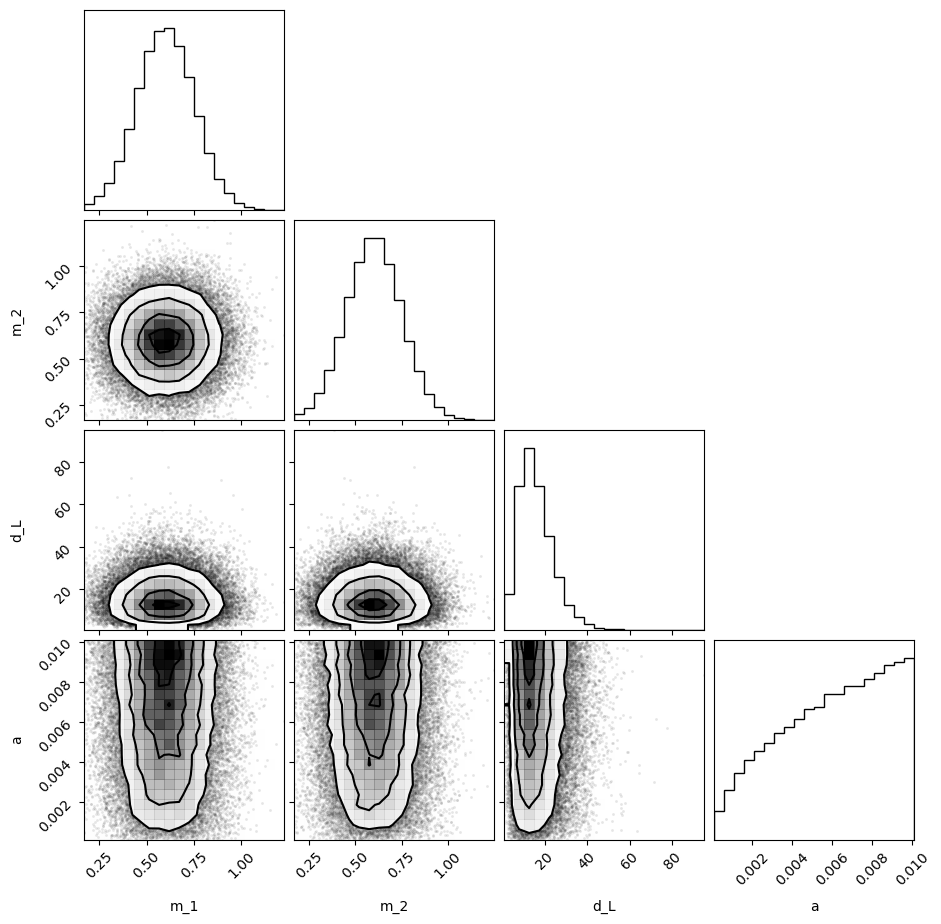

In [12]:
plt.close()
fig = corner(samps[:,::200].get().T,labels=list(test_prior.conditional_dict.keys()))
plt.show()

In [13]:
amps, fgws = get_amp_freq(samps)

In [14]:
test_hprior = PopulationHyperPrior(test_rng)

In [15]:
test_popmodel = PopModel(1e7,test_rng,hyperprior=test_hprior,Nsamp=1,thresh_compute_frac=1.0)

In [16]:
test_f, test_fg, N_res = test_popmodel.run_model(pop_theta)

To compare to the initial population draw, we need to run the thresholder on it.

In [17]:
data_N_res, data_coarse_fg = test_popmodel.thresher.serial_array_sort(xp.array([fgws,amps]),
                                                                      test_popmodel.fbins,
                                                                      snr_thresh=test_popmodel.thresh_val,
                                                                      compute_frac=test_popmodel.tc_frac)
data_fg = test_popmodel.reweight_foreground(data_coarse_fg)[1:]

In [18]:
data_N_res

array(1634)

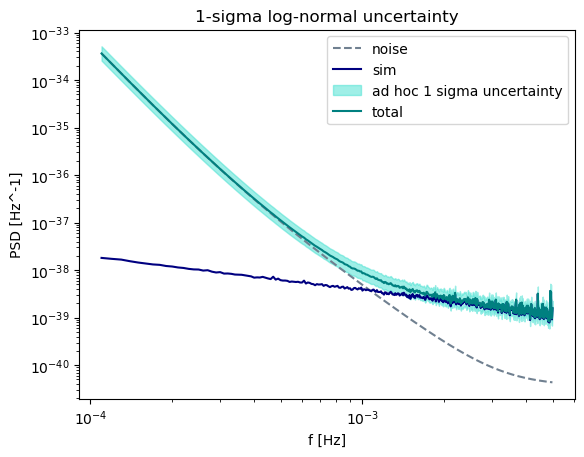

In [20]:
err = 0.15
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure()
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
plt.fill_between(total_fs,10**(np.log10(total_spec)-err),10**(np.log10(total_spec)+err),
                 color='turquoise',alpha=0.5,label='ad hoc 1 sigma uncertainty')
# plt.fill_between(total_fs,total_spec-err,total_spec+err,
#                  color='turquoise',alpha=0.5,label='ad hoc 1 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
plt.title('1-sigma log-normal uncertainty')
plt.show()

In [21]:
## setup w.r.t. the data
datadict = {'fg':data_fg,
            'fg_sigma':err, ## sigma_fg = 0.1 dex
            'Nres':data_N_res,
            'noise':lisa_noise_psd(test_f)}

In [22]:
test_popmodel.construct_likelihood(datadict)

In [23]:
scan_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}

In [24]:
test_mus = np.linspace(0.5,0.7,10)

In [25]:
likes = []
for tm in test_mus:
    scan_theta['m_mu'] = xp.array(tm)
    likes.append(test_popmodel.fg_N_ln_prob(scan_theta))
    

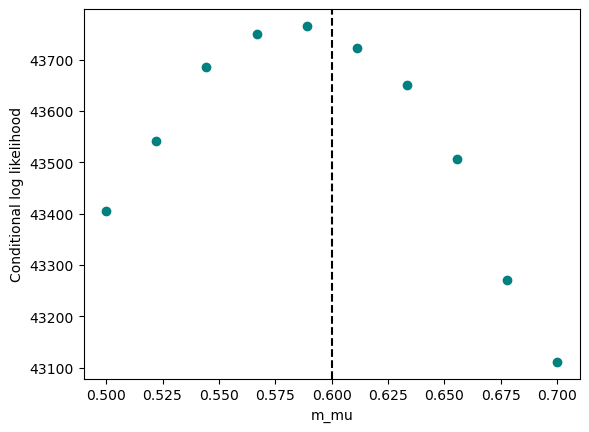

In [26]:
plt.figure()
plt.scatter(test_mus,likes,color='teal')
plt.axvline(pop_theta['m_mu'].get(),color='k',ls='--')
plt.xlabel("m_mu")
plt.ylabel("Conditional log likelihood")
plt.show()

Okay now for the other variables:

In [27]:
scan_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}

In [28]:
test_sigmas = np.linspace(0,0.5,10)

In [29]:
likes_sigma = []
for ts in test_sigmas:
    scan_theta['m_sigma'] = xp.array(ts)
    likes_sigma.append(test_popmodel.fg_N_ln_prob(scan_theta))
    

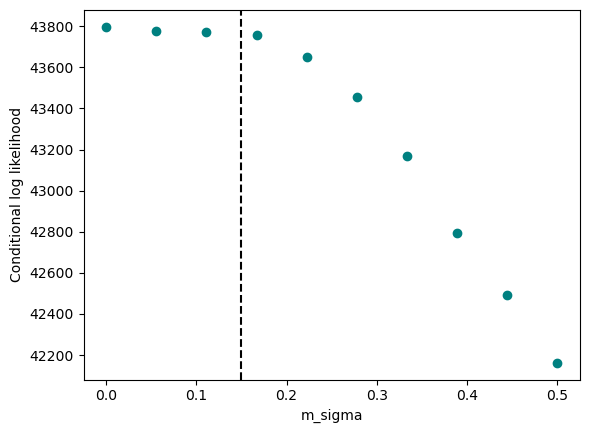

In [30]:
plt.figure()
plt.scatter(test_sigmas,likes_sigma,color='teal')
plt.axvline(pop_theta['m_sigma'].get(),color='k',ls='--')
plt.xlabel("m_sigma")
plt.ylabel("Conditional log likelihood")
# plt.ylim(-1000,0)
plt.show()

In [31]:
scan_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}

In [32]:
test_dga = np.linspace(0,10,10)

In [33]:
likes_dga = []
for tda in test_dga:
    scan_theta['d_gamma_a'] = xp.array(tda)
    likes_dga.append(test_popmodel.fg_N_ln_prob(scan_theta))
    

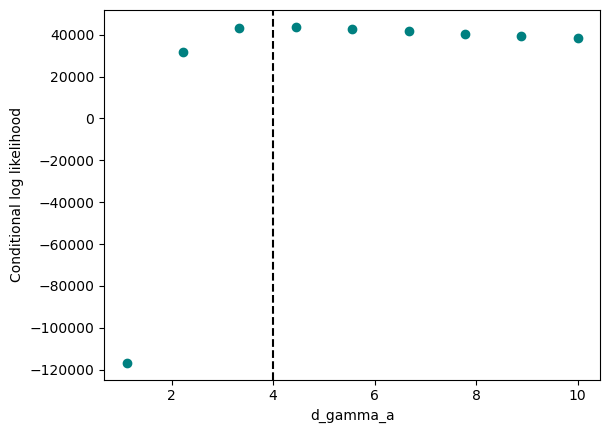

In [34]:
plt.figure()
plt.scatter(test_dga,likes_dga,color='teal')
plt.axvline(pop_theta['d_gamma_a'].get(),color='k',ls='--')
plt.xlabel("d_gamma_a")
plt.ylabel("Conditional log likelihood")
# plt.ylim(-75000,0)
plt.show()

In [35]:
scan_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}

In [36]:
test_dgb = np.linspace(0,10,10)

In [37]:
likes_dgb = []
for tdb in test_dgb:
    scan_theta['d_gamma_b'] = xp.array(tdb)
    likes_dgb.append(test_popmodel.fg_N_ln_prob(scan_theta))
    

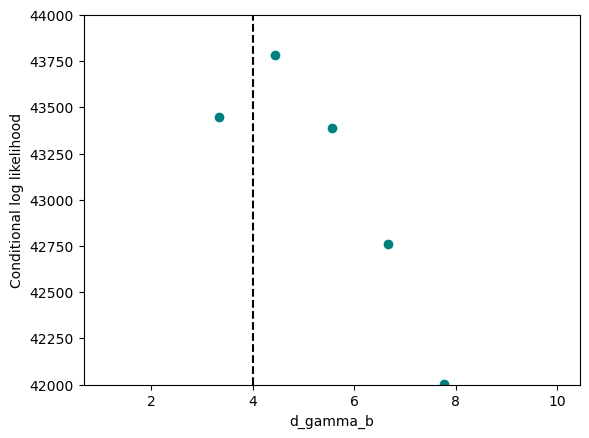

In [38]:
plt.figure()
plt.scatter(test_dgb,likes_dgb,color='teal')
plt.axvline(pop_theta['d_gamma_b'].get(),color='k',ls='--')
plt.xlabel("d_gamma_b")
plt.ylabel("Conditional log likelihood")
plt.ylim(42000,44000)
plt.show()

In [39]:
scan_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}

In [40]:
test_a = np.linspace(-1.5,1.5,10)

In [41]:
likes_a = []
for a in test_a:
    scan_theta['a_alpha'] = xp.array(a)
    likes_a.append(test_popmodel.fg_N_ln_prob(scan_theta))
    

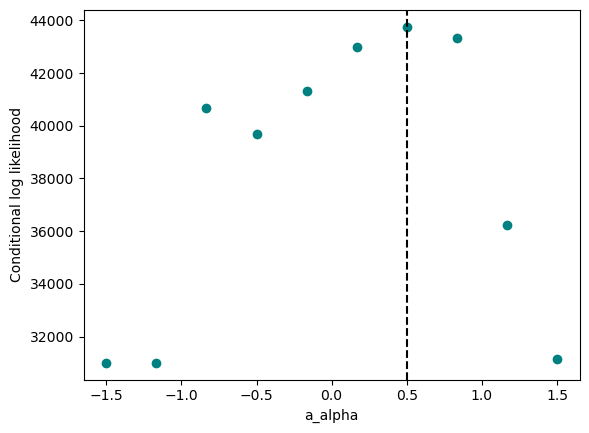

In [42]:
plt.figure()
plt.scatter(test_a,likes_a,color='teal')
plt.axvline(pop_theta['a_alpha'].get(),color='k',ls='--')
plt.xlabel("a_alpha")
plt.ylabel("Conditional log likelihood")
# plt.xlim(-1,1.5)
# plt.ylim(-500,0)
plt.show()

In [43]:
## check intrinsic scatter in the likelihood?
correct_likes = []
correct_astro = []
N_test = 250
for i in range(N_test):
    like_i, astro_i = test_popmodel.fg_N_ln_prob(pop_theta,return_spec=True)
    correct_likes.append(like_i)
    correct_astro.append(astro_i)

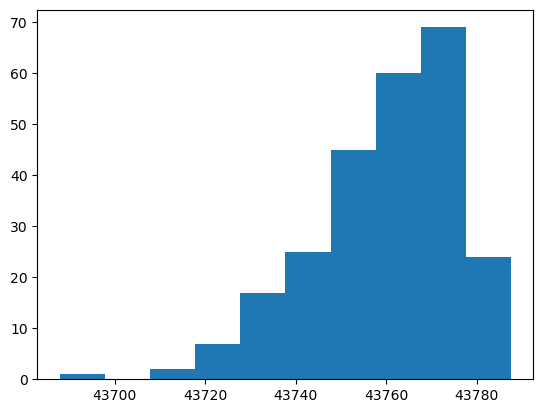

In [44]:
plt.figure()
plt.hist(correct_likes)
plt.show()

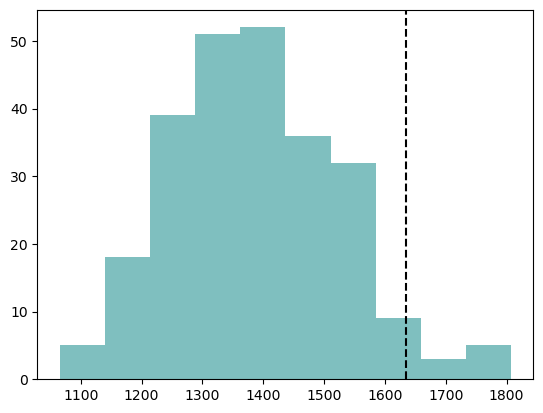

In [45]:
plt.figure()
plt.hist([correct_astro[i][2] for i in range(N_test)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

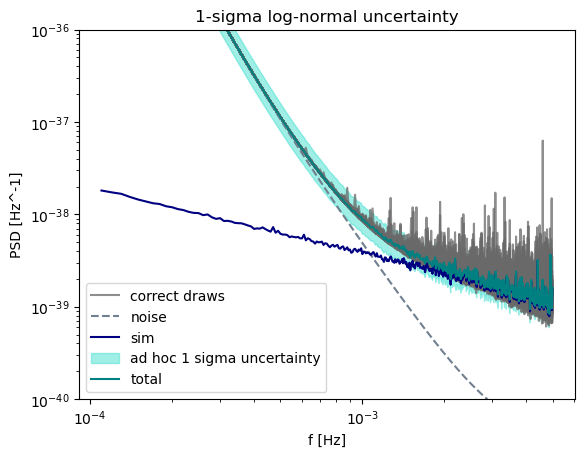

In [47]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure()
label_count = 0
for i in range(N_test):
    color='dimgrey'
    if label_count == 0:
        label='correct draws'
        label_count +=1
    else:
        label='__nolabel__'
        
    plt.loglog(correct_astro[i][0], lisa_noise_psd(test_f).get()[1:]+correct_astro[i][1],label=label,c=color,alpha=0.75)
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
plt.fill_between(total_fs,10**(np.log10(total_spec)-err),10**(np.log10(total_spec)+err),
                 color='turquoise',alpha=0.5,label='ad hoc 1 sigma uncertainty')
# plt.fill_between(total_fs,total_spec-err,total_spec+err,
#                  color='turquoise',alpha=0.5,label='ad hoc 1 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
plt.title('1-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
plt.show()

In [152]:
test_rng = xp.random.default_rng(42)

In [304]:
translation_dict = {0:'m_mu',
                    1:'m_sigma',
                    2:'d_gamma_a',
                    3:'d_gamma_b',
                    4:'a_alpha'}
## starting with the broader priors
eryn_hyperprior_dict = {0:st.uniform(test_rng,loc=0.5,scale=0.2,cast=True),
                        1:st.invgamma(test_rng,5,cast=True),
                        2:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        3:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        4:st.uniform(test_rng,0.25,0.75,cast=True)}
eryn_trans_dict = {translation_dict[key]:eryn_hyperprior_dict[key] for key in eryn_hyperprior_dict.keys()}

In [305]:
eryn_trans_dict

{'m_mu': <distributions.uniform at 0x74f4cc563fb0>,
 'm_sigma': <distributions.invgamma at 0x74f433ed32f0>,
 'd_gamma_a': <distributions.uniform at 0x74f4cc70ef60>,
 'd_gamma_b': <distributions.uniform at 0x74f433b9eb70>,
 'a_alpha': <distributions.uniform at 0x74f433b9ff80>}

In [306]:
eryn_prior = ProbDistContainer(eryn_hyperprior_dict)

In [307]:
eryn_popmodel = PopModel(1e7,test_rng,hyperprior=eryn_trans_dict)

In [308]:
eryn_popmodel.construct_likelihood(datadict)

In [309]:
log_like_fn = eryn_popmodel.fg_N_ln_prob

In [341]:
ndim = len(eryn_popmodel.hyperprior.hyperprior_dict)
nwalkers = 10

In [342]:
## MH with prior draws as the proposal function
PriorMove = DistributionGenerate({'model_0':eryn_prior})
MTPriorMove = MTDistGenMove({'model_0':eryn_prior},num_try=5,independent=False)

In [343]:
ensemble = EnsembleSampler(nwalkers,
                           ndim,
                           log_like_fn,
                           eryn_prior,
                           # moves=PriorMove, ## use default?
                           track_moves=True,
                          )
                            # pool=pool)

In [344]:
# starting positions
# randomize throughout prior
coords = eryn_prior.rvs(size=(nwalkers,))
# print(coords[i],type(coords[i]))
# check log_like, forcing the initialization to have finite log likelihood
log_like=xp.empty(nwalkers)
for i in tqdm(range(nwalkers)):
    log_like[i] = log_like_fn(coords[i])
    while xp.isinf(log_like[i]):
        coords[i] = eryn_prior.rvs(1)
        log_like[i] = log_like_fn(coords[i])
# log_like = xp.asarray([
#     log_like_fn(coords[i])#, means, invcov)
# for i in range(nwalkers)])
print("Log-likelihood:\n", log_like)

# check log_prior
log_prior = xp.asarray([eryn_prior.logpdf(coords[i]) for i in range(nwalkers)])
print("\nLog-prior:\n", log_prior)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.43it/s]

Log-likelihood:
 [43347.3031369  41291.78993456 43336.76455216 41738.30121997
 42812.08035402 43238.12521473 42952.97557753 41908.93944424
 40058.03665887 37759.1317578 ]

Log-prior:
 [-0.27772594  0.39560667  1.22303459  1.43934853  1.17894264  1.28619626
  1.32154557  1.41505823 -2.88661577  1.29514316]


In [345]:
nsteps = 10
burn = None
thin_by = 1
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.06s/it]


In [346]:
ensemble.get_log_like()

array([[[43350.90019276, 43452.38417821, 43353.5808754 , 41666.33348679,
         42944.67931295, 43280.25014208, 42993.90768523, 42087.06276116,
         39983.62785518, 37998.90438114]],

       [[43350.90019276, 43723.53677228, 43496.02549196, 42812.0102355 ,
         42944.67931295, 43745.36155528, 43029.12820278, 43278.72527167,
         39983.62785518, 37998.90438114]],

       [[43350.90019276, 43723.53677228, 43496.02549196, 43230.76416297,
         43379.93380936, 43745.36155528, 43079.65952604, 43278.72527167,
         39983.62785518, 37998.90438114]],

       [[43350.90019276, 43723.53677228, 43496.02549196, 43230.76416297,
         43379.93380936, 43745.36155528, 43079.65952604, 43499.94731813,
         39983.62785518, 37998.90438114]],

       [[43350.90019276, 43723.53677228, 43496.02549196, 43445.94196283,
         43421.9707723 , 43745.36155528, 43485.32126286, 43552.56724972,
         39983.62785518, 37998.90438114]],

       [[43543.58059467, 43723.53677228, 43496.025

In [347]:
ensemble.acceptance_fraction

array([[0.2, 0.2, 0.1, 0.4, 0.4, 0.1, 0.4, 0.6, 0.1, 0.3]])

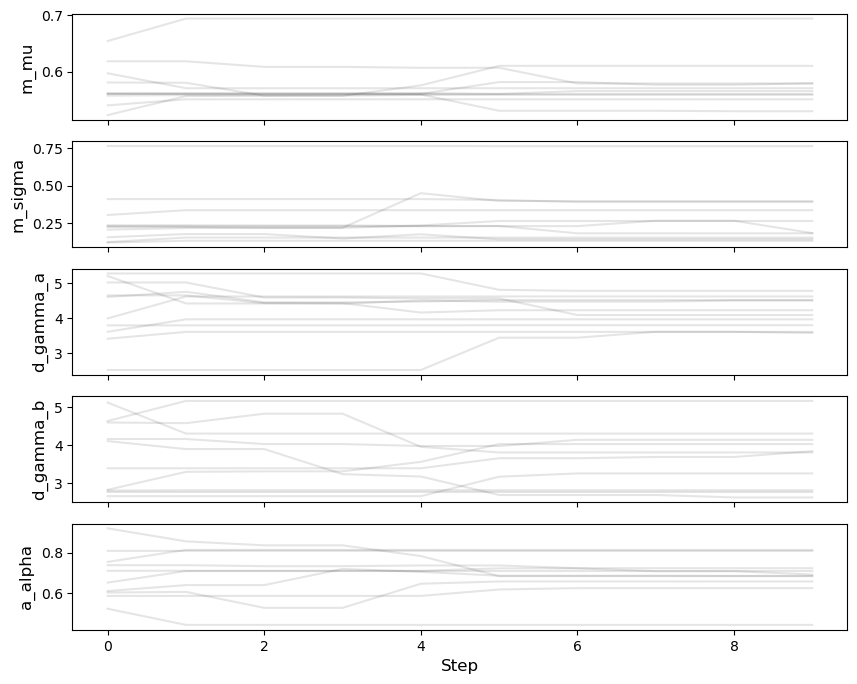

In [348]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

In [349]:
ensemble.get_chain()['model_0'].shape

(10, 1, 10, 1, 5)

In [350]:
# np.var(ensemble.get_chain()['model_0'].reshape(50,10,5),axis=0)

In [351]:
ensemble.get_chain()['model_0'].shape

(10, 1, 10, 1, 5)

In [352]:
ensemble.get_log_like().shape

(10, 1, 10)

In [353]:
from matplotlib import cycler
default_cycler=cycler(color=['navy','mediumorchid','teal','firebrick','goldenrod','slategrey'])
plt.rc('axes', prop_cycle=default_cycler)

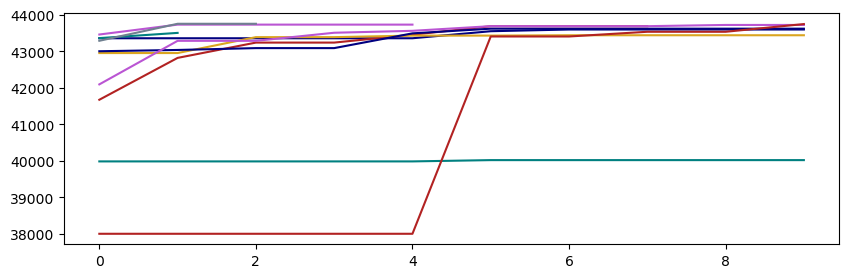

In [358]:
loglike = ensemble.get_log_posterior().reshape(ensemble.get_log_like().shape[0],nwalkers)
plt.figure(figsize=(10,3))
for i in range(nwalkers):
    plt.plot(loglike[:,i])
# plt.ylim(-500,0)
plt.show()

Who knows. Maybe just run it longer, idk.

In [356]:
nsteps = 100
burn = None
thin_by = 1
out = ensemble.run_mcmc(out, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

ValueError: The initial log_prior was NaN

In [326]:
ensemble.acceptance_fraction

array([[0.00833333]])

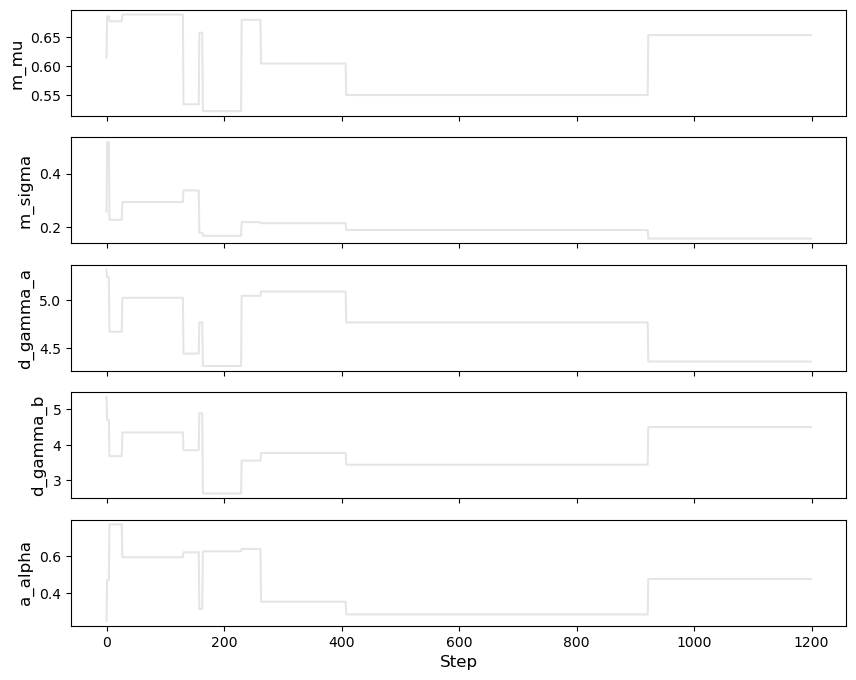

In [327]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

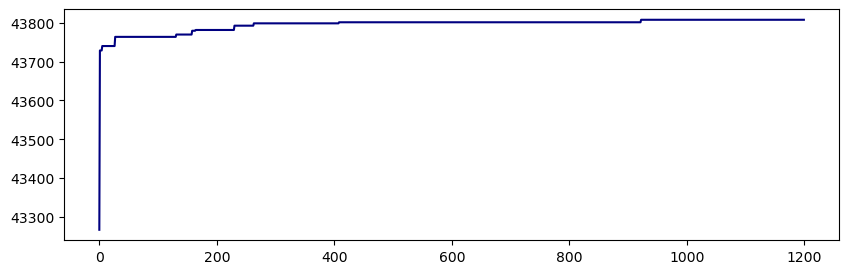

In [328]:
loglike = ensemble.get_log_like().reshape(ensemble.get_log_like().shape[0],1)
plt.figure(figsize=(10,3))
for i in range(1):
    plt.plot(loglike[:,i])
# plt.ylim(-3000,0)
plt.show()

In [49]:
np.var(ensemble.get_chain()['model_0'].reshape(ensemble.get_chain()['model_0'].shape[0],10,5),axis=0)

array([[1.76205101e-04, 1.00589989e-03, 3.77458629e-02, 2.59250189e-02,
        5.98656805e-05],
       [1.64556439e-04, 1.36037302e-03, 7.45733444e-02, 1.24994540e-01,
        1.11900097e-03],
       [2.70384540e-03, 3.36479119e-03, 1.02900006e-01, 4.13569433e-01,
        6.75636927e-03],
       [4.23695235e-03, 2.20774215e-02, 7.75479517e-02, 9.88672609e-01,
        4.57306951e-03],
       [1.87281507e-03, 6.19321144e-04, 2.09201791e-02, 1.50813947e-01,
        4.29524125e-03],
       [1.24608389e-03, 3.07944284e-03, 2.95565938e-03, 2.38170482e-01,
        2.24383782e-03],
       [6.89312938e-04, 3.62169694e-03, 1.92060955e-01, 3.39858473e-01,
        3.28083021e-03],
       [7.44500476e-04, 1.18271179e-04, 1.99604103e-02, 1.37821318e-02,
        1.19868630e-03],
       [1.72794085e-03, 9.46018288e-05, 6.33642276e-03, 1.81099143e-01,
        2.90554959e-03],
       [1.55475636e-03, 4.02418916e-03, 1.52956527e-01, 1.09773087e-01,
        5.01083364e-03]])

In [50]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [51]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

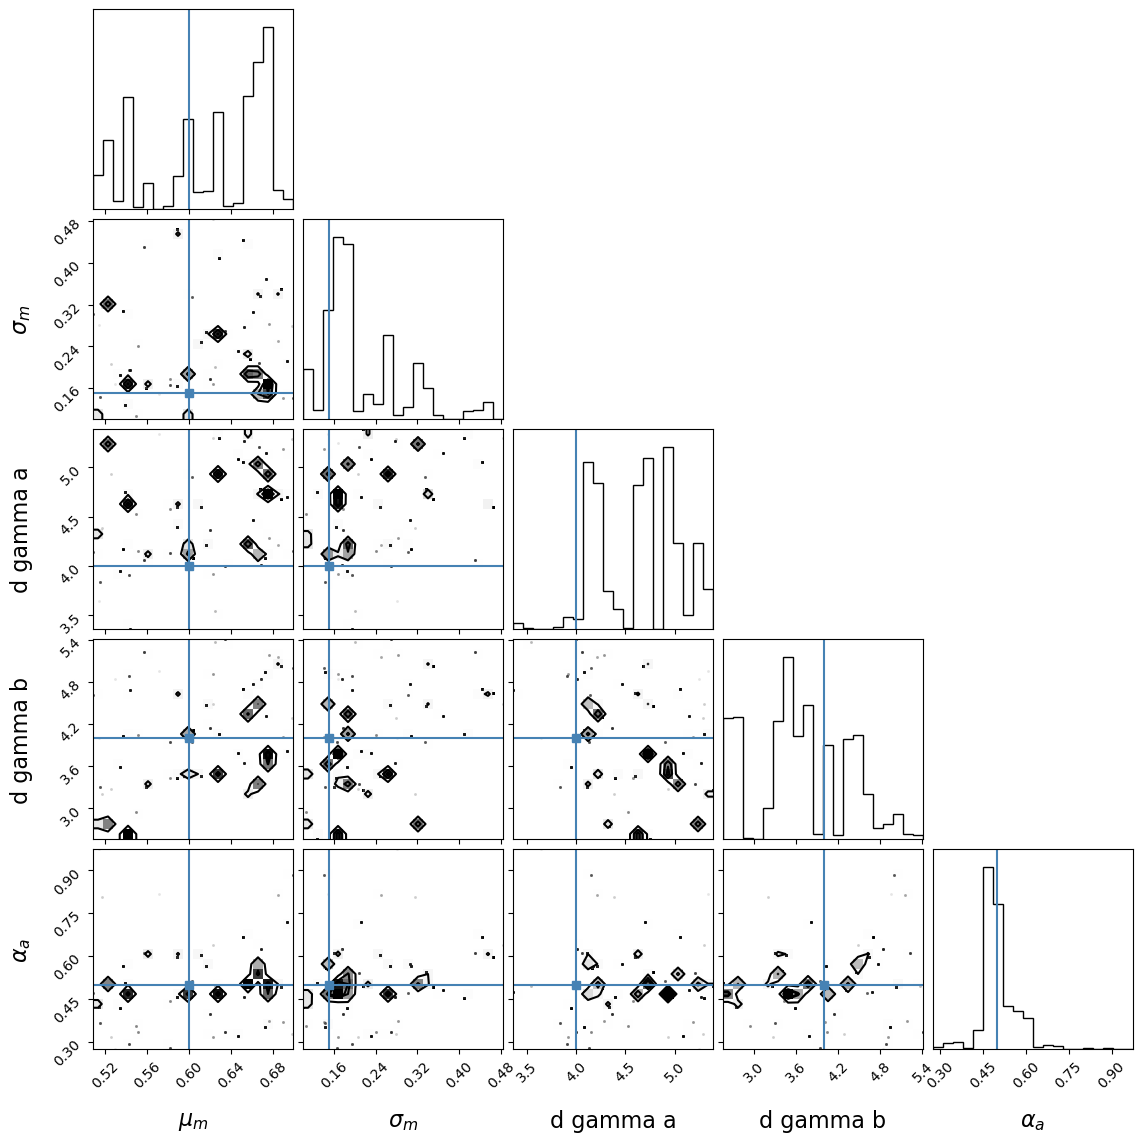

In [52]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

In [53]:
nsteps = 5000
burn = None
thin_by = 1
out = ensemble.run_mcmc(out, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [9:47:09<00:00,  7.05s/it]


In [54]:
ensemble.acceptance_fraction

array([[0.00054054, 0.00126126, 0.0027027 , 0.00234234, 0.0009009 ,
        0.00144144, 0.0009009 , 0.0009009 , 0.0009009 , 0.00216216]])

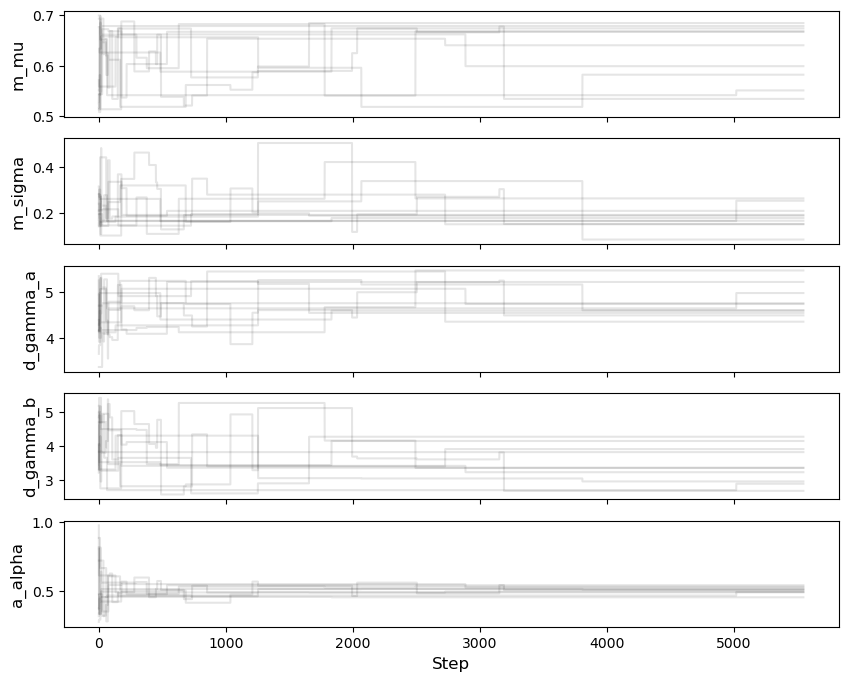

In [55]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

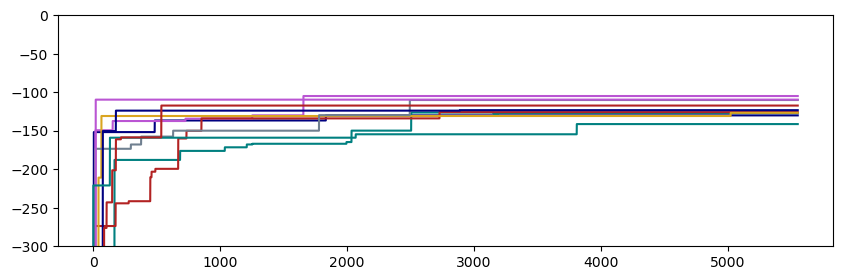

In [67]:
loglike = ensemble.get_log_like().reshape(ensemble.get_log_like().shape[0],10)
plt.figure(figsize=(10,3))
for i in range(10):
    plt.plot(loglike[:,i])
plt.ylim(-300,0)
plt.show()

In [59]:
np.var(ensemble.get_chain()['model_0'].reshape(ensemble.get_chain()['model_0'].shape[0],10,5),axis=0)

array([[1.35193698e-03, 6.49956772e-04, 2.14992682e-02, 1.06054255e-01,
        6.94298532e-06],
       [1.33606323e-03, 2.50643837e-04, 7.80392793e-02, 3.51750208e-01,
        2.13530591e-04],
       [3.02891176e-03, 1.47768031e-02, 1.12491821e-01, 7.69997004e-01,
        1.81352853e-03],
       [1.31503923e-03, 6.65441324e-03, 2.57477949e-01, 1.98284178e-01,
        5.39620113e-04],
       [2.12091607e-04, 7.37357183e-04, 1.15127148e-02, 1.91873459e-02,
        4.97997130e-04],
       [2.12738873e-03, 5.03119297e-03, 3.60813658e-01, 5.93750334e-01,
        2.65418282e-04],
       [1.03128451e-03, 4.05948343e-04, 4.37977368e-02, 6.35457758e-02,
        4.71295718e-04],
       [7.59299109e-05, 1.17403183e-05, 2.01610085e-03, 1.39292843e-03,
        1.20600915e-04],
       [2.40437803e-03, 1.07420274e-02, 1.50463911e-01, 2.71259653e-01,
        3.59145507e-04],
       [5.29685693e-04, 4.02329071e-04, 9.79676458e-02, 6.19889806e-02,
        9.23384919e-04]])

In [60]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [61]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

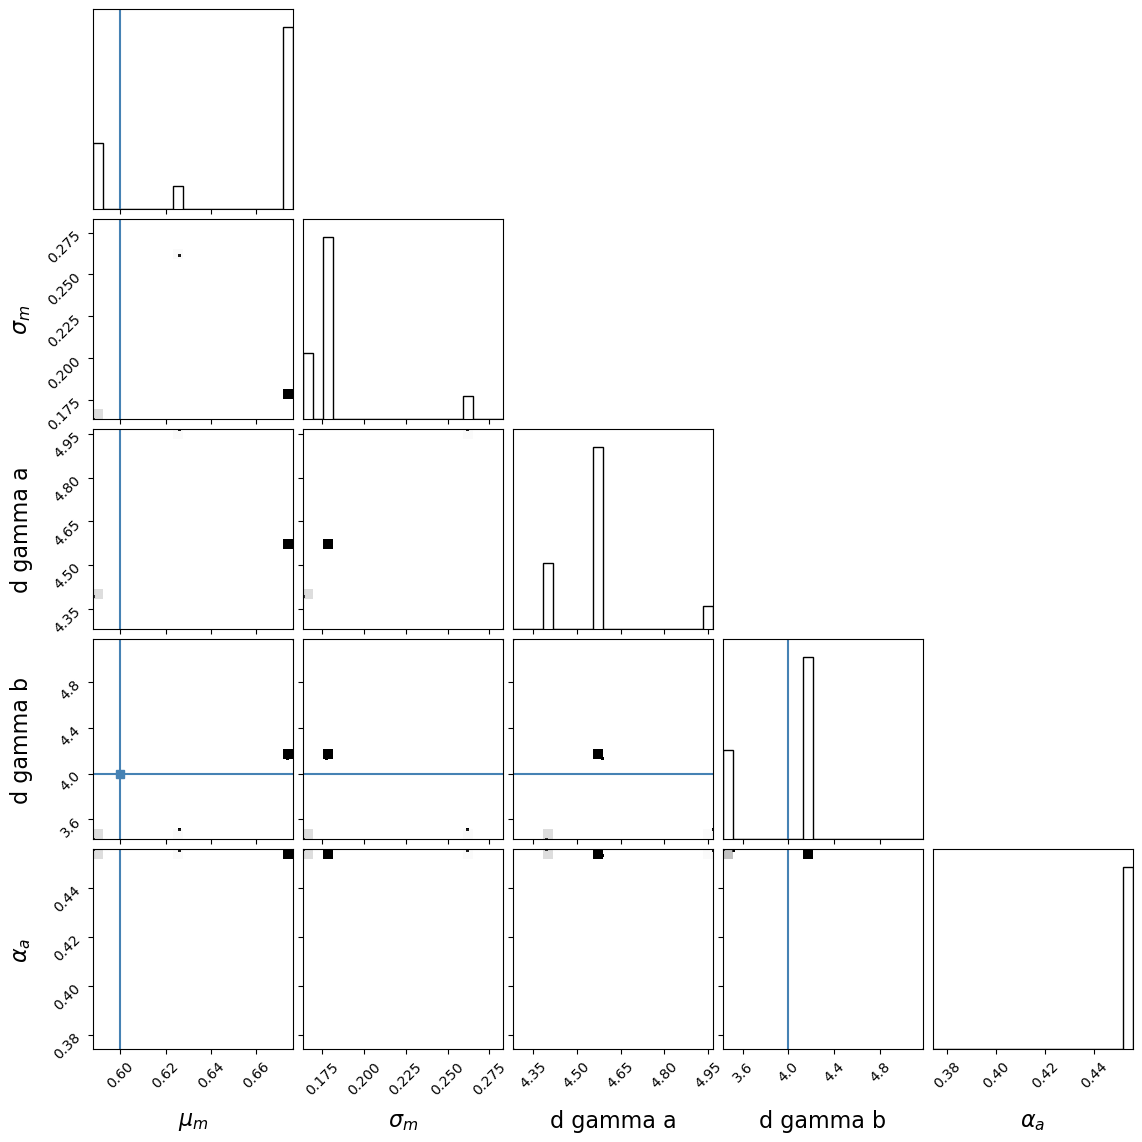

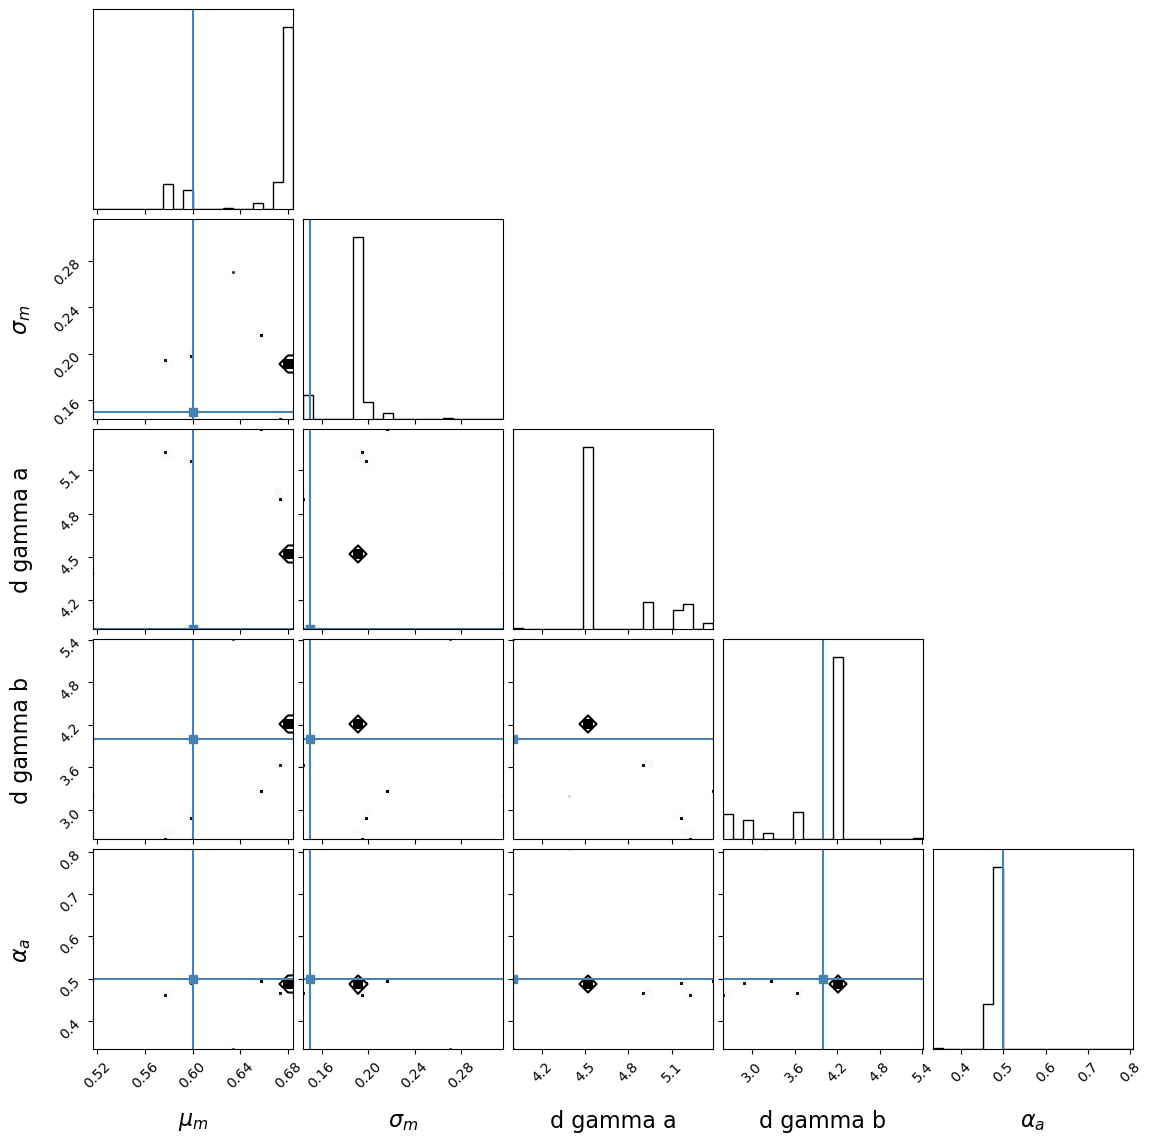

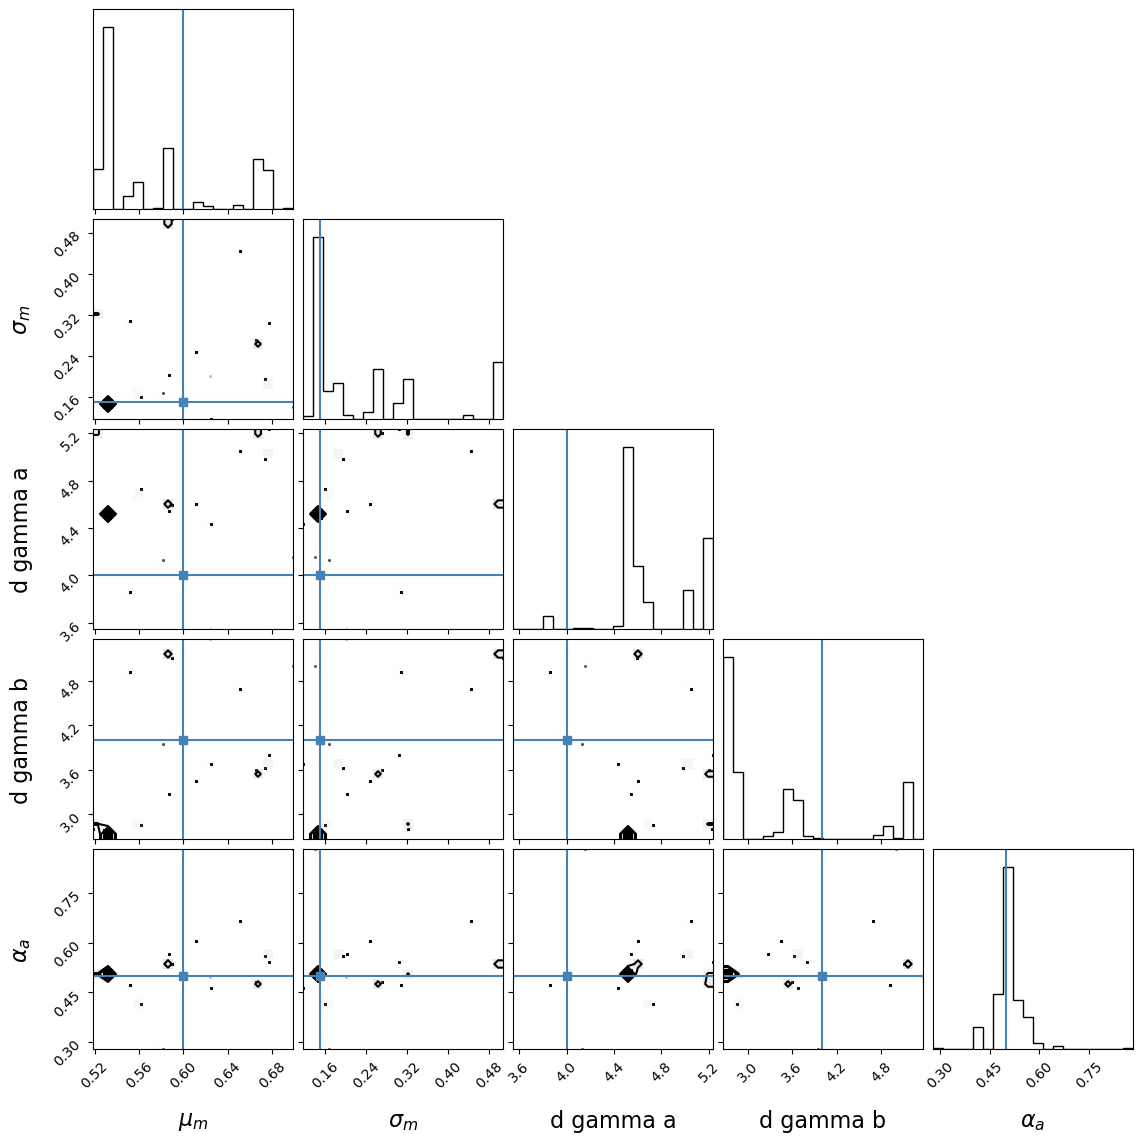

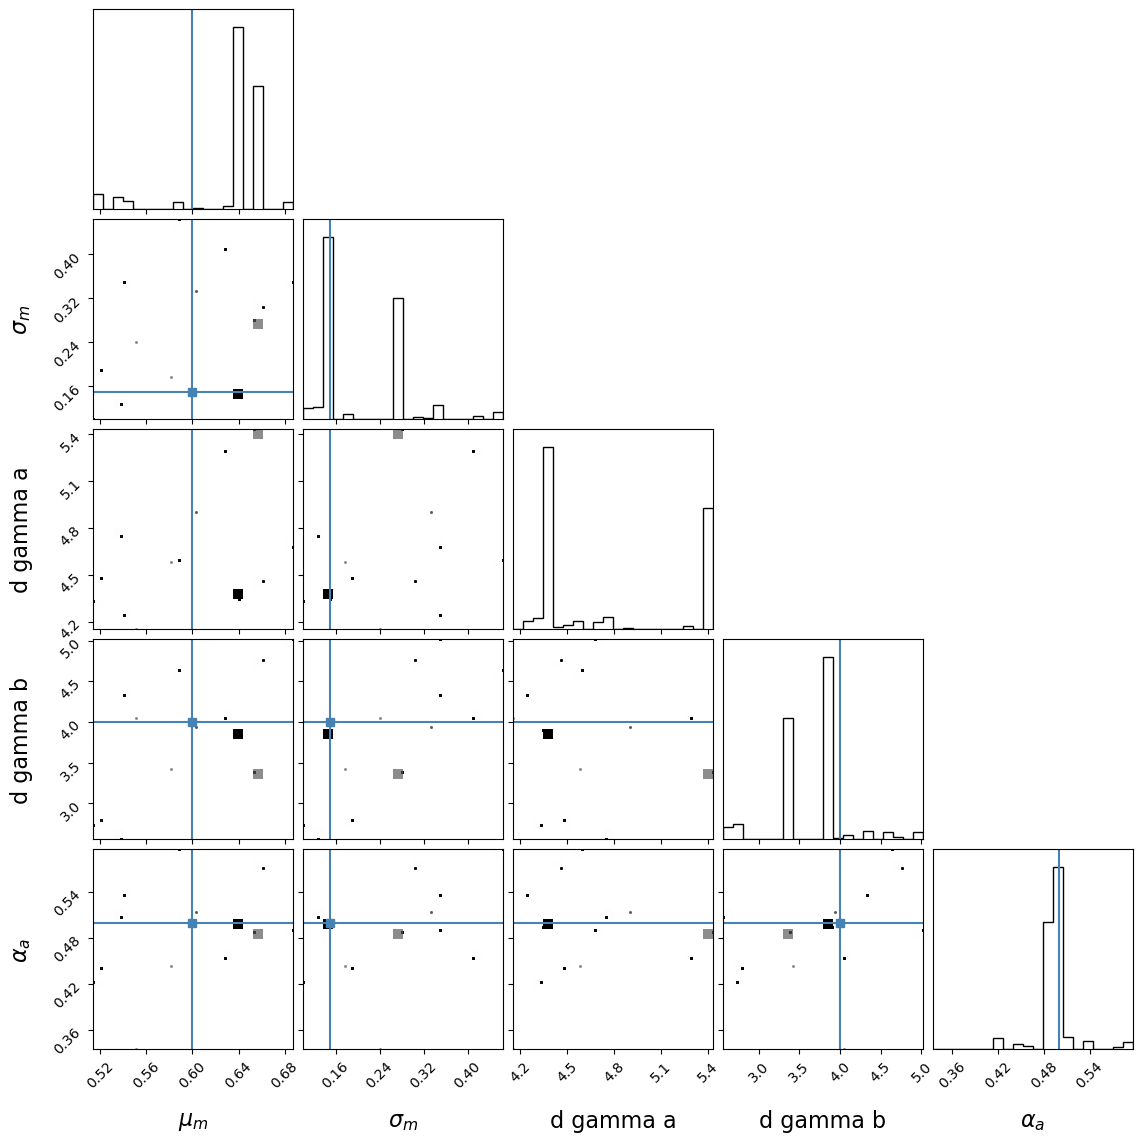

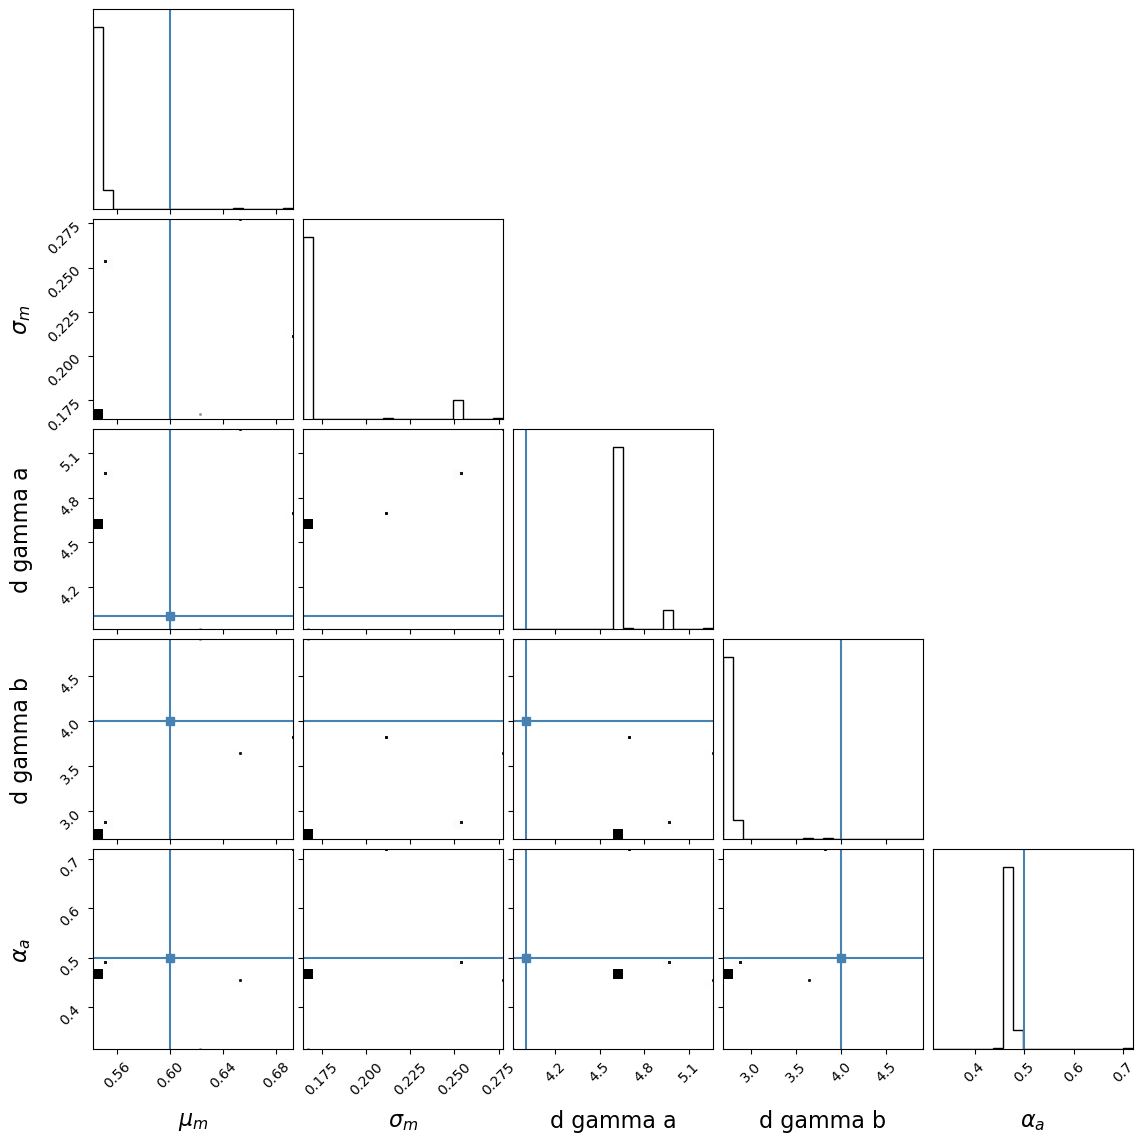

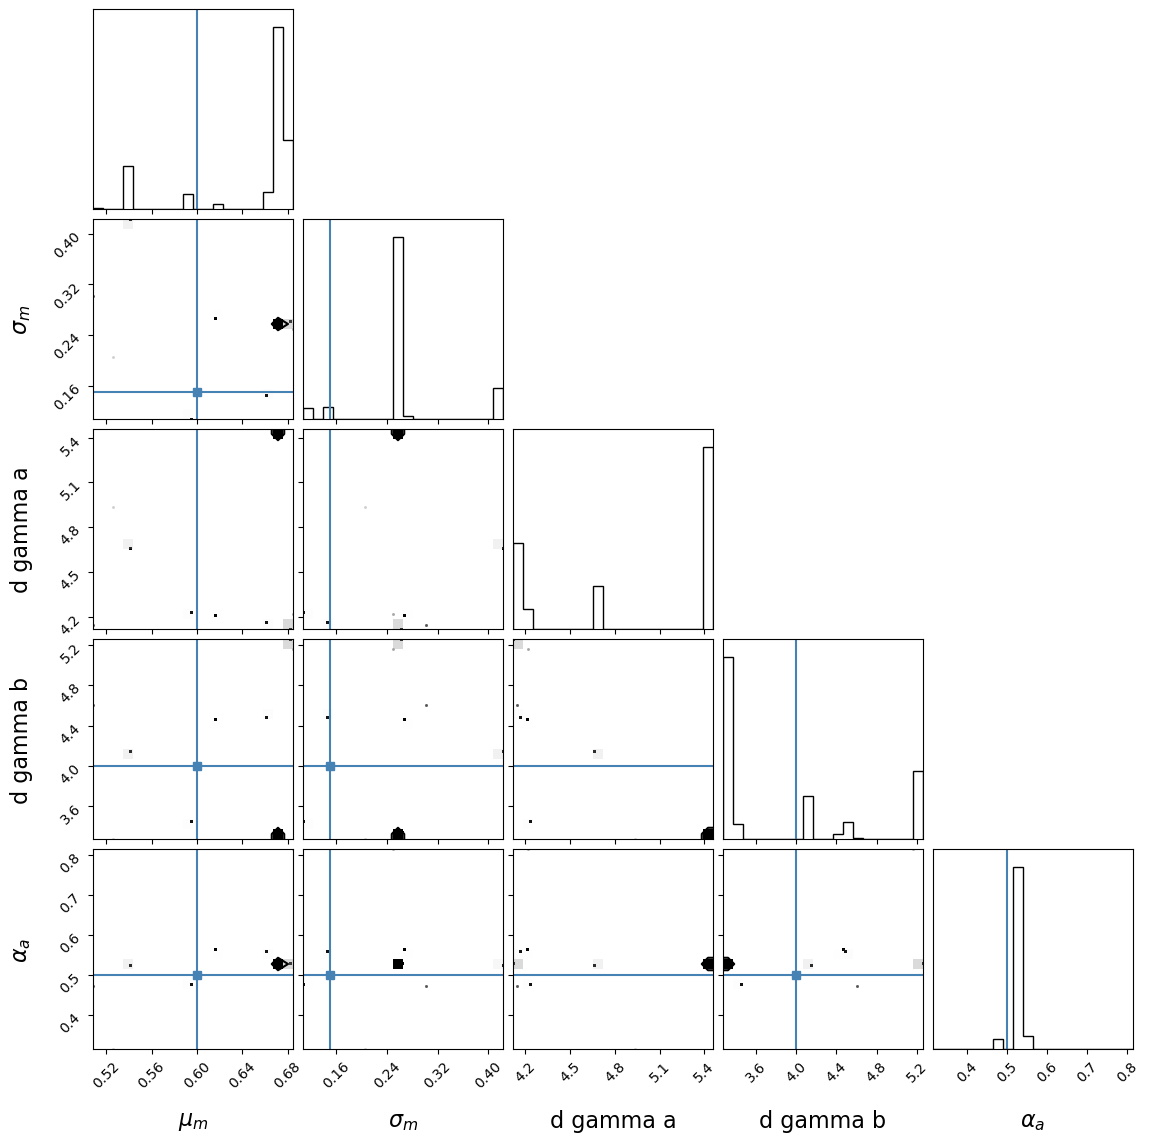

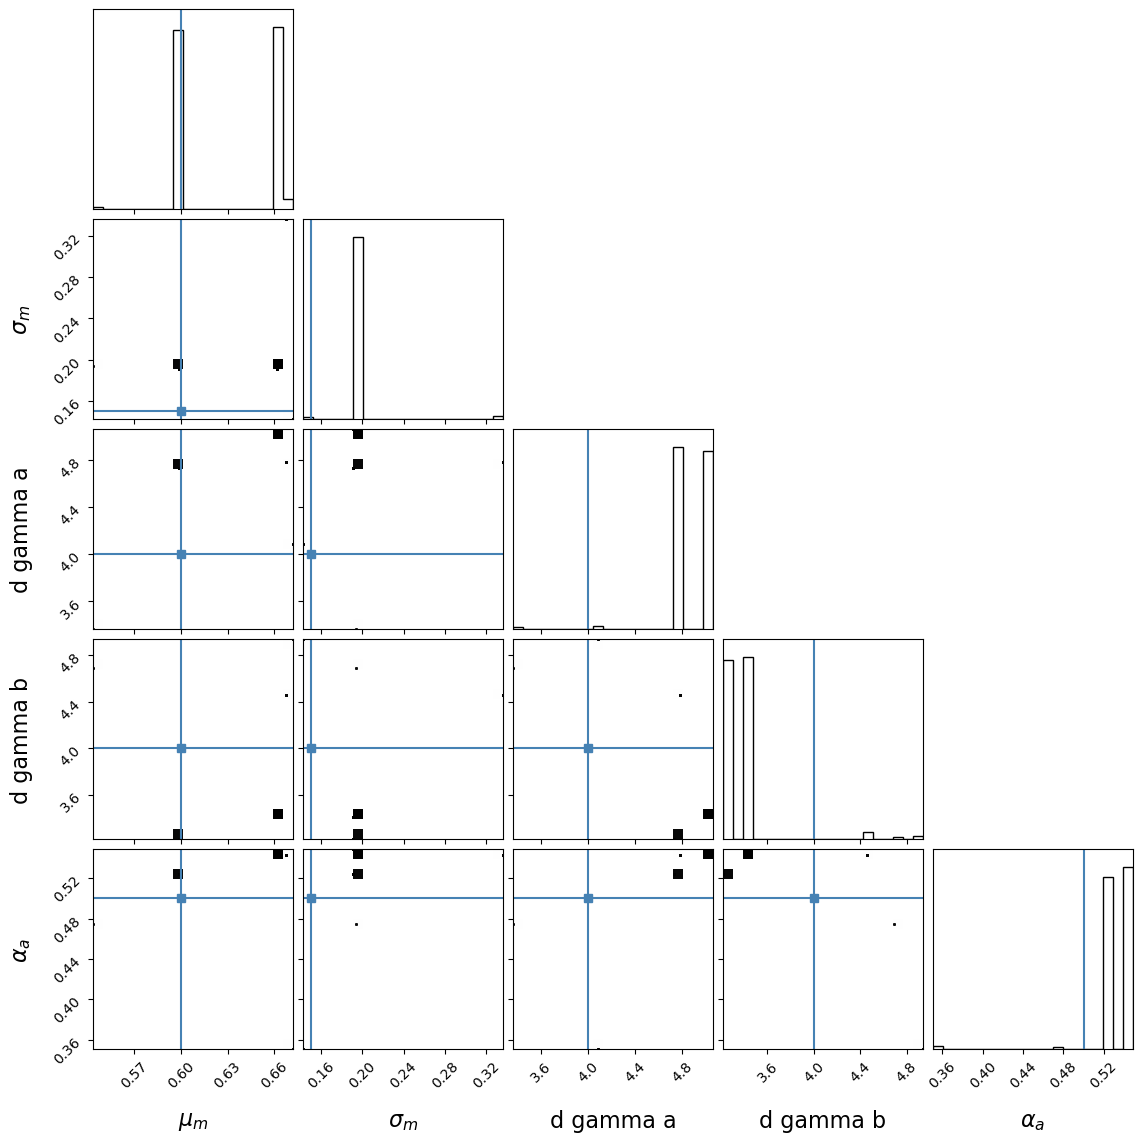

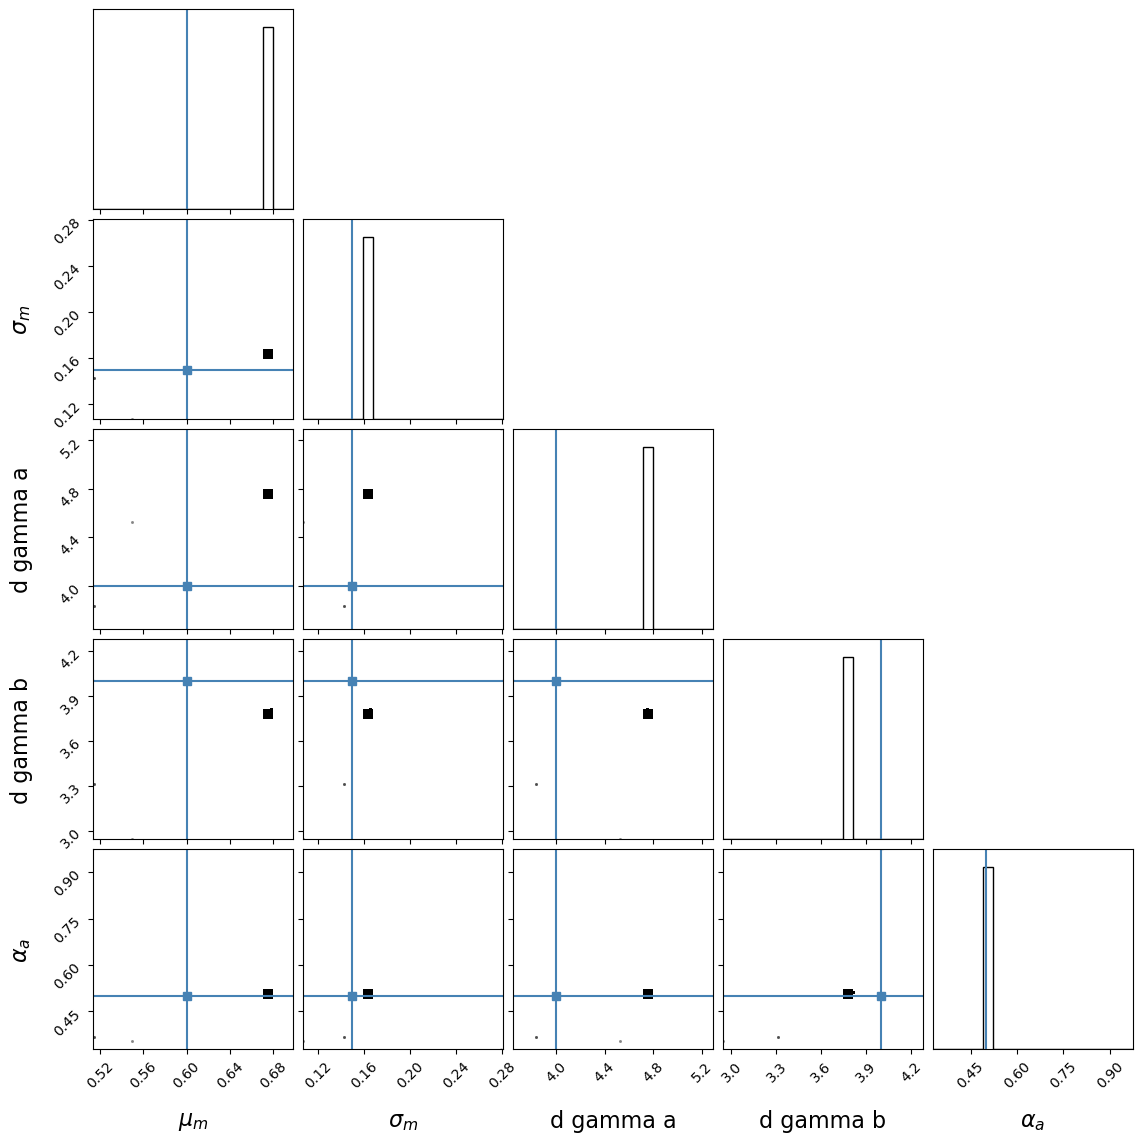

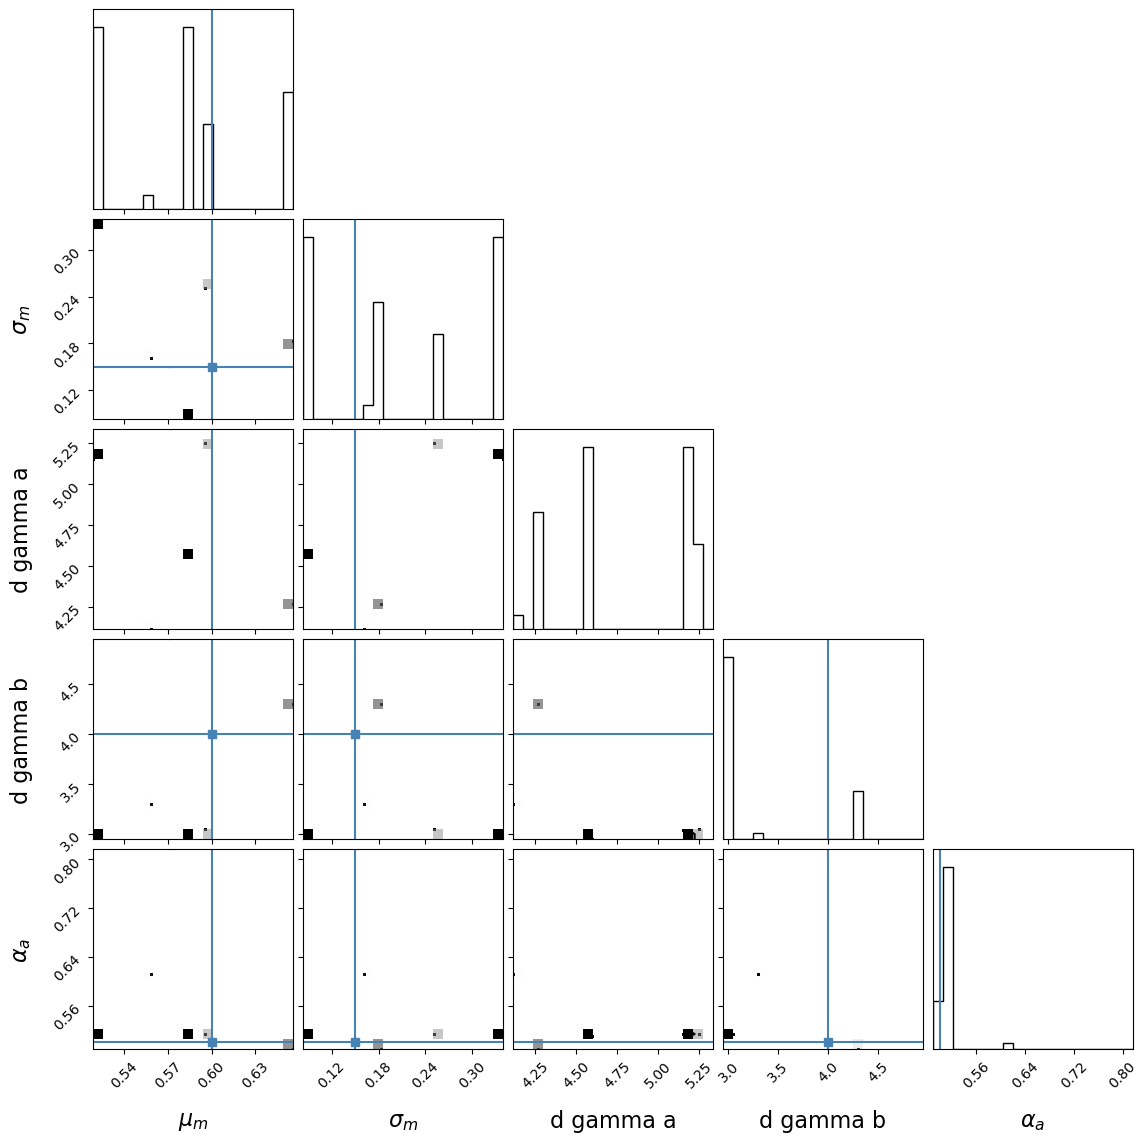

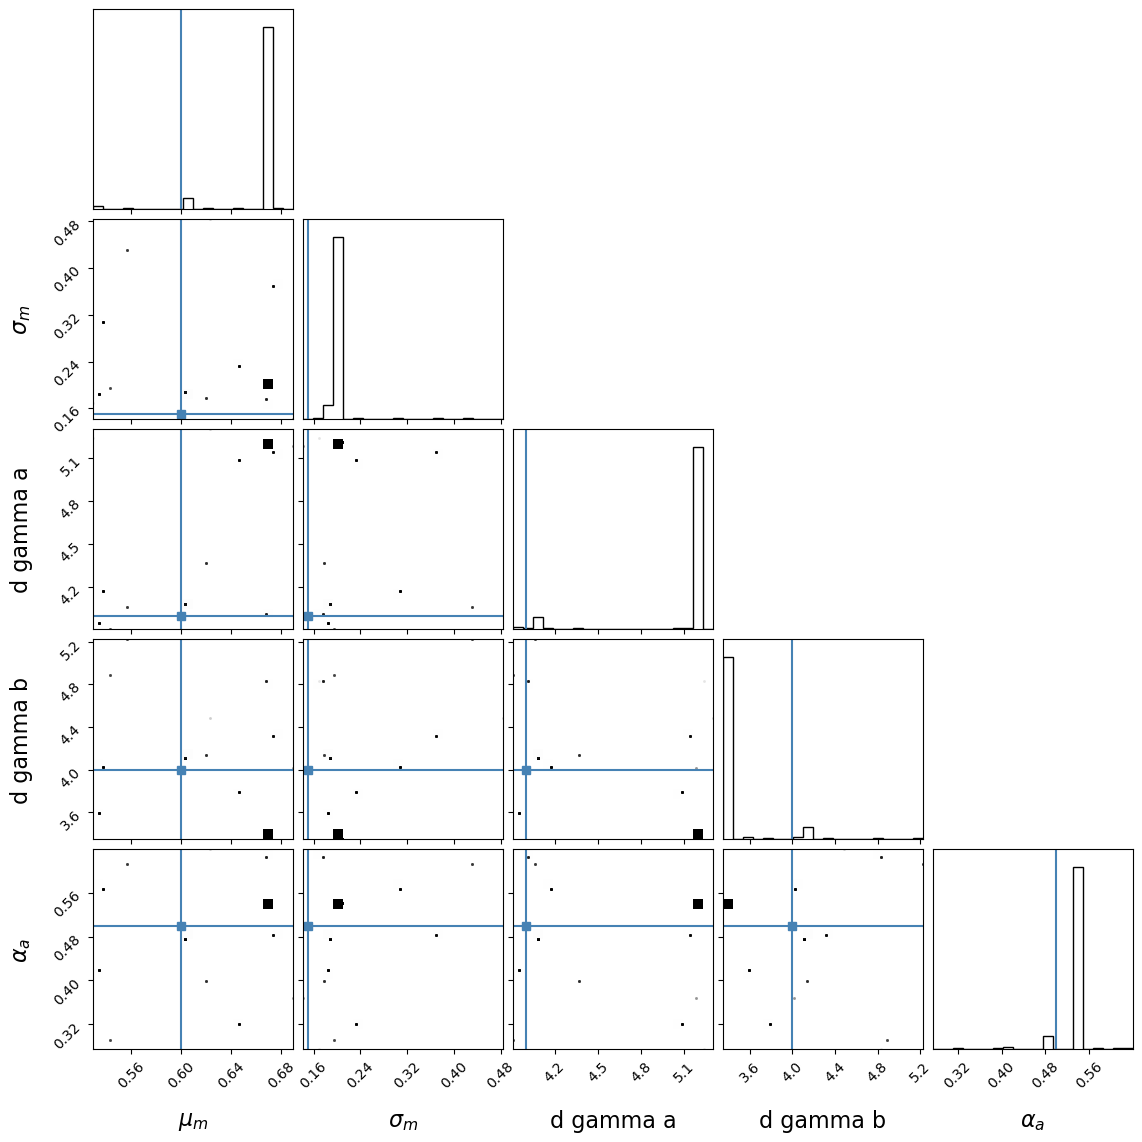

In [66]:
for i in range(10):
    plt.rcParams.update({'axes.labelsize':16})
    # samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
    samples = ensemble.get_chain()['model_0'].reshape(ensemble.get_chain()['model_0'].shape[0],10,5)[:,i,:]
    corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
    # plt.savefig('first_initial_result.png',dpi=200)
    plt.show()